In [21]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle
import matplotlib.pyplot as plt
from torchvision.transforms import InterpolationMode

In [22]:
class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        return image, target

class LoadData:
    def __init__(self, binary=True):
        self.transform = self._get_transforms()
        self.classes = 37 
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_transforms(self):
        return transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10)
        ])

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, split=split
        )

    def data_loaders(self, batch_size, split_ratio):
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size)


In [23]:
class Train:
    def __init__(self, model, train_loader, val_loader, epochs=10, lr=0.001):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)  # 使用传入的学习率
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def save_metrics(self):
        with open('training_results.csv', 'w') as f:
            f.write('Epoch,Train Loss,Validation Loss,Validation Accuracy\n')
            for i in range(len(self.train_losses)):
                f.write(f"{i+1},{self.train_losses[i]},{self.validation_losses[i]},{self.validation_accuracies[i]*100}%\n")

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            total_train_loss = 0
            total_train_samples = 0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * images.size(0)
                total_train_samples += images.size(0)
            average_train_loss = total_train_loss / total_train_samples
            val_loss, val_accuracy = self.validate()
            self.train_losses.append(average_train_loss)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
            self.scheduler.step()
            print(f'Epoch {epoch+1}/{self.epochs}: Train Loss: {average_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')
        
        # Save metrics after training
        self.save_metrics()



    def validate(self):
        self.model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        average_val_loss = total_val_loss / len(self.val_loader.dataset)
        accuracy = correct / total
        return average_val_loss, accuracy


def adjust_batchnorm(model, freeze_bn, update_stats):
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.requires_grad_(not freeze_bn)
            module.track_running_stats = update_stats


In [24]:
def save_results(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Results saved to {filename}")

def load_results(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Results loaded from {filename}")
    return data

def run_experiments():
    configurations = [
        (['fc'], 0.001),
        (['layer4', 'fc'], 0.0001),
        (['layer4', 'fc'], 0.00001)
    ]
    bn_settings = [(True, False), (True, True), (False, True)]
    results = {}
    
    for layers, lr in configurations:
        for freeze_bn, update_stats in bn_settings:
            print(f"Running experiment with layers: {layers}, LR: {lr}, BN Freeze: {freeze_bn}, Stats Update: {update_stats}")
            data = LoadData(binary=False)
            train_loader, val_loader = data.data_loaders(batch_size=32, split_ratio=0.8)
            model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            adjust_batchnorm(model, freeze_bn, update_stats)
            trainer = Train(model, train_loader, val_loader, lr=lr)  # 确保传递 lr 参数
            trainer.train()
            val_loss, val_accuracy = trainer.validate()
            results[(str(layers), lr, freeze_bn, update_stats)] = {
                'validation_loss': val_loss,
                'validation_accuracy': val_accuracy
            }
    save_results(results, "experiment_results.pkl")
    return results

# Run and save experiments
experiment_results = run_experiments()

# Optionally, load results
loaded_results = load_results("experiment_results.pkl")


Running experiment with layers: ['fc'], LR: 0.001, BN Freeze: True, Stats Update: False
Epoch 1/10: Train Loss: 2.7909, Validation Loss: 909.4244, Validation Accuracy: 2.7174%
Epoch 2/10: Train Loss: 1.5949, Validation Loss: 4680.0113, Validation Accuracy: 3.1250%
Epoch 3/10: Train Loss: 1.2194, Validation Loss: 97748.8723, Validation Accuracy: 2.8533%
Epoch 4/10: Train Loss: 0.9853, Validation Loss: 222053.3519, Validation Accuracy: 2.9891%
Epoch 5/10: Train Loss: 0.8355, Validation Loss: 5493154.7174, Validation Accuracy: 2.0380%
Epoch 6/10: Train Loss: 0.4143, Validation Loss: 651353.7554, Validation Accuracy: 3.2609%
Epoch 7/10: Train Loss: 0.2533, Validation Loss: 358143.5584, Validation Accuracy: 3.2609%
Epoch 8/10: Train Loss: 0.1840, Validation Loss: 231315.2099, Validation Accuracy: 2.1739%
Epoch 9/10: Train Loss: 0.1555, Validation Loss: 199421.3893, Validation Accuracy: 2.1739%
Epoch 10/10: Train Loss: 0.1338, Validation Loss: 180768.3933, Validation Accuracy: 2.1739%
Runnin

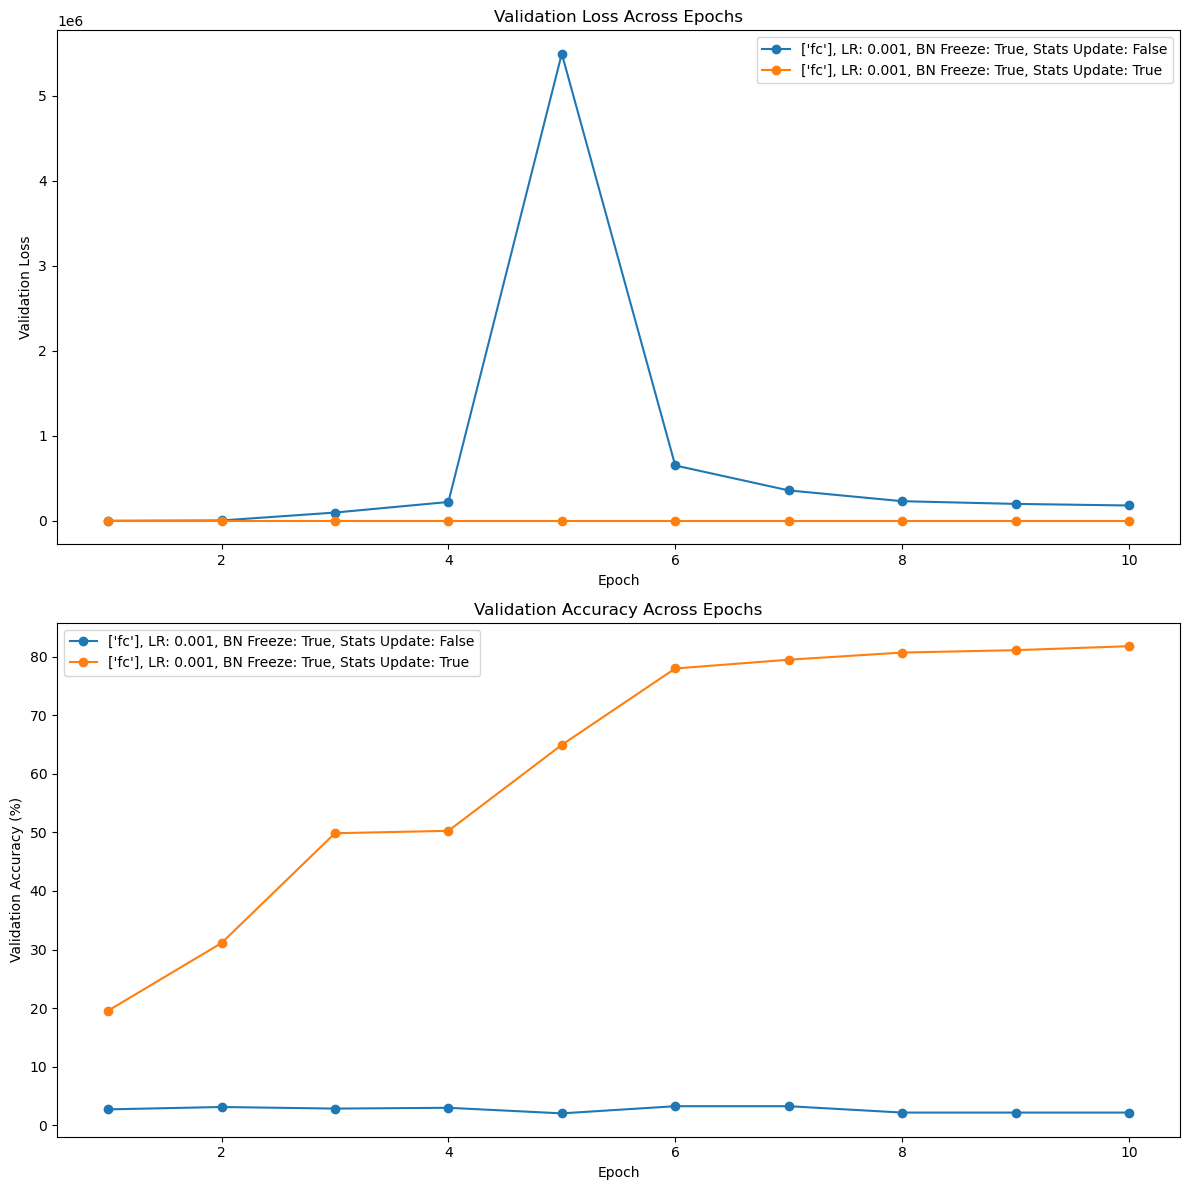

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data Structure to hold the parsed data
experiment_data = {
    "['fc'], LR: 0.001, BN Freeze: True, Stats Update: False": {
        'validation_losses': [909.4244, 4680.0113, 97748.8723, 222053.3519, 5493154.7174, 651353.7554, 358143.5584, 231315.2099, 199421.3893, 180768.3933],
        'validation_accuracies': [2.7174, 3.1250, 2.8533, 2.9891, 2.0380, 3.2609, 3.2609, 2.1739, 2.1739, 2.1739]
    },
    "['fc'], LR: 0.001, BN Freeze: True, Stats Update: True": {
        'validation_losses': [3.5621, 2.6431, 1.7735, 1.6569, 1.2942, 0.6922, 0.6664, 0.6372, 0.6637, 0.6495],
        'validation_accuracies': [19.5652, 31.1141, 49.8641, 50.2717, 64.9457, 77.9891, 79.4837, 80.7065, 81.1141, 81.7935]
    },
    # More configurations can be added here
}

def plot_data(experiment_data):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    # Plot each experiment's data
    for config, data in experiment_data.items():
        epochs = np.arange(1, 11)  # 10 epochs
        # Validation Loss Plot
        axs[0].plot(epochs, data['validation_losses'], marker='o', label=config)
        # Validation Accuracy Plot
        axs[1].plot(epochs, data['validation_accuracies'], marker='o', label=config)

    axs[0].set_title('Validation Loss Across Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Validation Loss')
    axs[0].legend()

    axs[1].set_title('Validation Accuracy Across Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Accuracy (%)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_data(experiment_data)



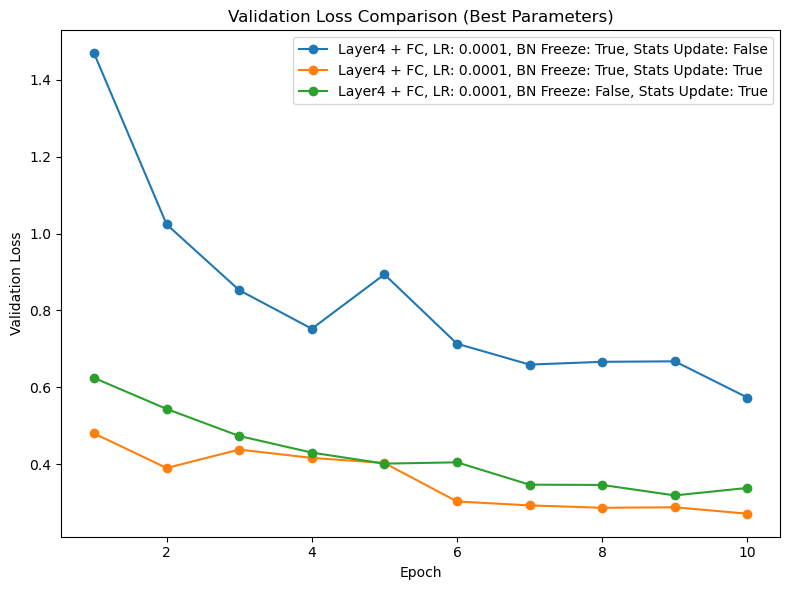

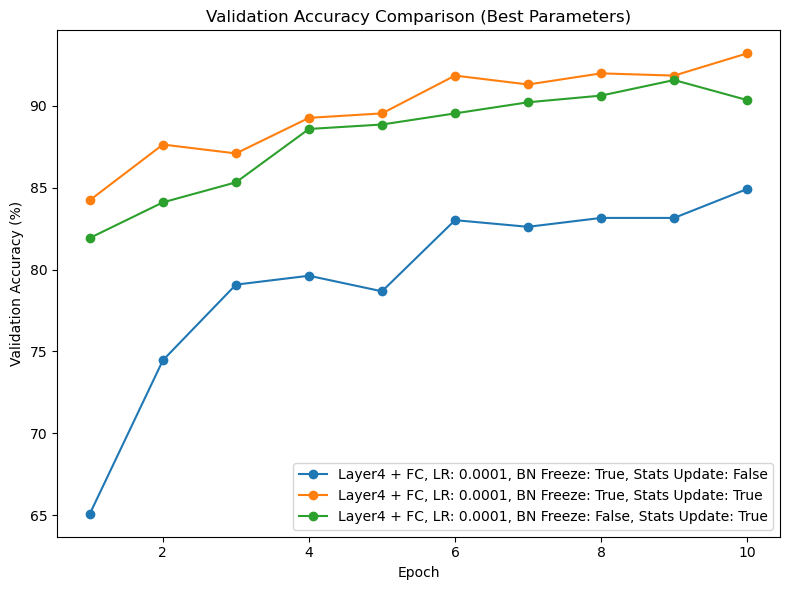

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 定义相关的实验数据，主要关注最佳的 Layer4 + FC, LR: 0.0001 组
experiment_data = {
    "Layer4 + FC, LR: 0.0001, BN Freeze: True, Stats Update: False": {
        'validation_losses': [1.4685, 1.0236, 0.8526, 0.7523, 0.8936, 0.7134, 0.6591, 0.6663, 0.6676, 0.5734],
        'validation_accuracies': [65.0815, 74.4565, 79.0761, 79.6196, 78.6685, 83.0163, 82.6087, 83.1522, 83.1522, 84.9185]
    },
    "Layer4 + FC, LR: 0.0001, BN Freeze: True, Stats Update: True": {
        'validation_losses': [0.4801, 0.3901, 0.4381, 0.4164, 0.4031, 0.3031, 0.2929, 0.2867, 0.2880, 0.2713],
        'validation_accuracies': [84.2391, 87.6359, 87.0924, 89.2663, 89.5380, 91.8478, 91.3043, 91.9837, 91.8478, 93.2065]
    },
    "Layer4 + FC, LR: 0.0001, BN Freeze: False, Stats Update: True": {
        'validation_losses': [0.6244, 0.5437, 0.4734, 0.4302, 0.4015, 0.4049, 0.3468, 0.3461, 0.3189, 0.3383],
        'validation_accuracies': [81.9293, 84.1033, 85.3261, 88.5870, 88.8587, 89.5380, 90.2174, 90.6250, 91.5761, 90.3533]
    }
}

def plot_validation_loss(experiment_data):
    epochs = np.arange(1, 11)  # 假设每个实验都有10个epoch的数据

    plt.figure(figsize=(8, 6), dpi=100)

    # 验证损失对比
    for config, data in experiment_data.items():
        plt.plot(epochs, data['validation_losses'], marker='o', linestyle='-', label=config)

    plt.title('Validation Loss Comparison (Best Parameters)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_validation_accuracy(experiment_data):
    epochs = np.arange(1, 11)  # 假设每个实验都有10个epoch的数据

    plt.figure(figsize=(8, 6), dpi=100)

    # 验证准确率对比
    for config, data in experiment_data.items():
        plt.plot(epochs, data['validation_accuracies'], marker='o', linestyle='-', label=config)

    plt.title('Validation Accuracy Comparison (Best Parameters)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数分别绘制两张图
plot_validation_loss(experiment_data)
plot_validation_accuracy(experiment_data)
